In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
import sklearn
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.model_selection import GridSearchCV
#from functions import *
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [0]:
df = pd.read_csv('/content/drive/My Drive/shot_logs.csv', sep = ";", decimal = ".")

# MODIFICATION DES FEATURES

In [0]:
##rename columns 
df.columns = ['id_match','matchup', 'place','game_result','score',
              'shot_nb','quarter','game_clock', 'clock_remain',
                'dribbles','touch_time','shot_distance', 'pts_type',
                'shot_result','defender','id_defender', 'defender_dist',
                 'FGM','Pts','player_name', 'player_id']
df['place'] = df['place'].replace(['H'],'Home')
df['place'] = df['place'].replace(['A'],'Away')
df['game_result'] = df['game_result'].replace(['W'],'Win')
df['game_result'] = df['game_result'].replace(['L'],'Loss')

In [0]:
#convert feet to meter
df['shot_distance'] = df.shot_distance.apply(lambda x: round(x*0.3048,2))
df['defender_dist'] = df.defender_dist.apply(lambda x:round(x*0.3048,2))
#convert game_clock in correct format
df['game_clock'] = df.game_clock.apply(lambda x : x[:5])
df['game_clock'] = df['game_clock'].str.replace(',', '.').astype(float)

#split the matchup into date, team & opponenet
def matchup_split(x):
    (a,b) = x.split('-')
    a = a.strip()
    return(a)
def team_split(x):
    (a,b) = x.split('-')
    if '@' in b:
        (b1, b2) = b.split('@')
    if 'vs.' in b:
        (b1, b2) = b.split('vs.')
    b1 = b1.strip()   
    return(b1)    
def opponent_split(x):
    (a,b) = x.split('-')
    if '@' in b:
        (b2, b1) = b.split('@')
    if 'vs.' in b:
        (b2, b1) = b.split('vs.')
    b1 = b1.strip()
    return(b1)

df['date'] = df['matchup'].apply(matchup_split)
df['date'] = df['date'].apply(pd.to_datetime)
df['team'] = df['matchup'].apply(team_split)
df['opponent'] = df['matchup'].apply(opponent_split)

df.loc[df['shot_distance'] <=4, 'shot_type'] = 'Paint'
df.loc[(df['shot_distance'] >4) & (df['shot_distance'] <= 6.5),  'shot_type'] = 'Mid_Range'
df.loc[(df['shot_distance'] >6.5)& (df['shot_distance'] <=7.23), 'shot_type'] = 'Long_2'
df.loc[df['shot_distance'] >7.23, 'shot_type'] = '3_Points'

TEMPS_CHRONO = [6, 20]
def temps_chrono(value):
    if value > TEMPS_CHRONO[1]: 
        return 'quick_shot'
    if value > TEMPS_CHRONO[0] and value < TEMPS_CHRONO[1]:
        return 'normal_shot'
    else:
        return 'last_possession_shot'
#Créate features'shot_comment', # var 'stress'
df['shot_comment'] = df['clock_remain'].map(temps_chrono)
df["stress"] = [1 if m == 'last_possession_shot'
                else 0 for m in df["shot_comment"]]

# add 0 sec when clock_remain = 0
df['clock_remain'] = df.apply(lambda x : 0 if x.game_clock == 0.00 else x.clock_remain, axis = 1)

# drop columns 
#df = df.drop(['id_match', 'matchup', 'id_defender', 'player_id', 'Pts', 'shot_result'], axis = 1)

In [0]:
# # Saving a new dataset
df.to_csv('/content/drive/My Drive/new_nba.csv', index = False)

In [96]:
df = pd.read_csv('/content/drive/My Drive/new_nba.csv')
# drop columns 
df.drop(['id_match', 'matchup', 'id_defender', 'player_id', 'Pts', 'shot_result'], axis = 1, inplace=True)
df.head()

,place,game_result,score,shot_nb,quarter,game_clock,clock_remain,dribbles,touch_time,shot_distance,pts_type,defender,defender_dist,FGM,player_name,date,team,opponent,shot_type,shot_comment,stress
0,Away,Win,24,1,1,1.09,10.8,2,1.9,2.35,2,"Anderson, Alan",0.40,1,brian roberts,2015-03-04,CHA,BKN,Paint,normal_shot,0
1,Away,Win,24,2,1,0.14,3.4,0,0.8,8.60,3,"Bogdanovic, Bojan",1.86,0,brian roberts,2015-03-04,CHA,BKN,3_Points,last_possession_shot,1
2,Away,Win,24,3,1,0.00,0.0,3,2.7,3.08,2,"Bogdanovic, Bojan",0.27,0,brian roberts,2015-03-04,CHA,BKN,Paint,last_possession_shot,1
3,Away,Win,24,4,2,11.47,10.3,2,1.9,5.24,2,"Brown, Markel",1.04,0,brian roberts,2015-03-04,CHA,BKN,Mid_Range,normal_shot,0
4,Away,Win,24,5,2,10.34,10.9,2,2.7,1.13,2,"Young, Thaddeus",0.34,0,brian roberts,2015-03-04,CHA,BKN,Paint,normal_shot,0


In [0]:
#Let's try to see if we can observe variable differences between successful and unsuccessful baskets.
made = dataset[dataset['FGM'] == 1]
miss = dataset[dataset['FGM'] == 0]

In [0]:
made.describe()

In [0]:
miss.describe()

In [0]:
# try to see if we can fill the Nan by a logic way ... 
df[(df['clock_remain'].isna()==True)]

,place,game_result,score,shot_nb,quarter,game_clock,clock_remain,dribbles,touch_time,shot_distance,pts_type,defender,defender_dist,FGM,player_name,date,team,opponent,shot_comment,stress
24,Away,Win,12,6,2,0.04,NaN,0,0.7,7.68,3,"Butler, Jimmy",1.10,0,brian roberts,2015-02-25,CHA,CHI,last_possession_shot,1
54,Home,Loss,-1,14,4,0.01,NaN,5,3.7,10.49,3,"Hill, George",1.10,0,brian roberts,2015-02-08,CHA,IND,last_possession_shot,1
76,Home,Win,7,10,3,0.01,NaN,2,3.6,3.99,2,"Butler, Rasual",0.76,1,brian roberts,2015-02-05,CHA,WAS,last_possession_shot,1
129,Home,Win,25,7,2,0.02,NaN,5,5.0,3.66,2,"Williams, Mo",1.22,0,brian roberts,2015-01-19,CHA,MIN,last_possession_shot,1
134,Home,Win,25,12,3,0.03,NaN,2,2.3,5.46,2,"Daniels, Troy",0.82,0,brian roberts,2015-01-19,CHA,MIN,last_possession_shot,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128008,Away,Loss,-10,3,2,0.02,NaN,0,1.2,6.28,3,"Blake, Steve",0.52,0,jarrett jack,2014-11-15,BKN,POR,last_possession_shot,1
128017,Away,Loss,-10,12,4,0.03,NaN,5,4.1,2.59,2,"Lillard, Damian",1.37,0,jarrett jack,2014-11-15,BKN,POR,last_possession_shot,1
128018,Away,Loss,-8,1,1,0.02,NaN,24,21.1,1.46,2,"Barbosa, Leandro",1.52,1,jarrett jack,2014-11-13,BKN,GSW,last_possession_shot,1
128051,Home,Win,31,2,1,0.16,NaN,3,3.7,0.79,2,"Telfair, Sebastian",1.65,1,jarrett jack,2014-11-03,BKN,OKC,last_possession_shot,1


In [0]:
## we dropp the 4947 -> 3.92% of dataset 
df = df.dropna()

# ANALYSE PREDICTIVE

## Regression Logistique

In [0]:
### suppression des valeurs abérantes 
df = df[(df['touch_time']>=0)  &(df['touch_time']<24)] 
df = df[df['shot_distance']>=0]
df = df[df['shot_distance']<13]
df = df[(df['defender_dist']>0.00) & (df['defender_dist']<=12)]
df = df[df['dribbles']<28]



In [0]:
df = df.dropna()

In [53]:
df.corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'))

,score,shot_nb,quarter,game_clock,clock_remain,dribbles,touch_time,shot_distance,pts_type,defender_dist,FGM,stress
score,1.0,0.0063,0.0015,0.0018,-0.014,-0.011,-0.011,0.0093,0.025,0.034,0.057,0.015
shot_nb,0.0063,1.0,0.69,-0.24,-0.029,0.1,0.094,0.0051,-0.0015,-0.038,-0.0032,0.035
quarter,0.0015,0.69,1.0,-0.016,-0.053,0.035,0.019,0.032,0.046,-0.0084,-0.014,0.042
game_clock,0.0018,-0.24,-0.016,1.0,0.031,-0.053,-0.037,-0.0059,-0.033,0.01,0.0026,-0.062
clock_remain,-0.014,-0.029,-0.053,0.031,1.0,-0.086,-0.13,-0.16,-0.025,-0.0033,0.095,-0.59
dribbles,-0.011,0.1,0.035,-0.053,-0.086,1.0,0.87,-0.16,-0.3,-0.27,-0.043,0.058
touch_time,-0.011,0.094,0.019,-0.037,-0.13,0.87,1.0,-0.089,-0.25,-0.22,-0.066,0.069
shot_distance,0.0093,0.0051,0.032,-0.0059,-0.16,-0.16,-0.089,1.0,0.75,0.62,-0.2,0.077
pts_type,0.025,-0.0015,0.046,-0.033,-0.025,-0.3,-0.25,0.75,1.0,0.47,-0.12,0.031
defender_dist,0.034,-0.038,-0.0084,0.01,-0.0033,-0.27,-0.22,0.62,0.47,1.0,-0.016,-0.017


In [0]:
y=df['FGM']
X = df[[ 'place', 'game_result', 'shot_nb', 'game_clock','clock_remain',
        'dribbles', 'touch_time', 'shot_distance', 'defender_dist', 
        'shot_comment', 'stress' ]]

In [0]:
# Get dummies and standardScaler separatly
from sklearn.preprocessing import StandardScaler 
sc_x = StandardScaler()
num_col = X.select_dtypes([np.number]).columns
cat_col = X.select_dtypes("object").columns
X_num = X[num_col]
X_cat =  pd.get_dummies(X[cat_col],drop_first=True)
from sklearn.model_selection import train_test_split
X_train_num, X_test_num, X_train_cat, X_test_cat, y_train_log, y_test_log = train_test_split(X_num, X_cat, y, test_size =0.2, stratify = y)
X_train_num_norm = pd.DataFrame(sc_x.fit_transform(X_train_num),columns=X_train_num.columns, index = X_train_num.index)
X_test_num_norm = pd.DataFrame(sc_x.transform(X_test_num),columns=X_test_num.columns, index = X_test_num.index)

X_train_log = pd.merge(X_train_num_norm, X_train_cat,left_index=True, right_index=True)
X_test_log = pd.merge(X_test_num_norm, X_test_cat,left_index=True, right_index=True)
X_train_log_col = X_train_log.columns

In [0]:
# ## recherche des meilleurs paramètres
# ##--> liblinear ; intercept_scaling = 0.7 ; warm_start = True
# from sklearn.model_selection import GridSearchCV
# lr = LogisticRegression()
# params = {'intercept_scaling': [0.2,0.4,0.6,0.7,0.8,0.9],
#           'warm_start' : [True, False]}

# grid_rtc =  GridSearchCV(estimator=lr, param_grid= params, cv = 10)
# grid_rtc.fit(X_train_log, y_train_log)

In [0]:
#grid_rtc.best_estimator_.get_params()

In [0]:
# Application du modèle 
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier_blcd = LogisticRegression(class_weight='balanced')
classifier.fit(X_train_log, y_train_log)
classifier_blcd.fit(X_train_log, y_train_log)


# DummyClassifier to predict only target 0
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent').fit(X_train_log, y_train_log)
dummy_pred = dummy.predict(X_test_log)

In [59]:
print("Logistic regression".center(50, "-"))
print("Logistic regression score on train :",classifier.score(X_train_log, y_train_log))  ### donne l'accuracy
print("Logistic regression score on test", classifier.score(X_test_log, y_test_log))
print("Dummy classificator".center(50, "-"))
print('Unique predicted labels: ', (np.unique(dummy_pred)))
# checking accuracy
print('Dummy predictor Test score: ', accuracy_score(y_test_log, dummy_pred))


---------------Logistic regression----------------
Logistic regression score on train : 0.60697253741161
Logistic regression score on test 0.6070958723894097
---------------Dummy classificator----------------
Unique predicted labels:  [0]
Dummy predictor Test score:  0.5446061503042263


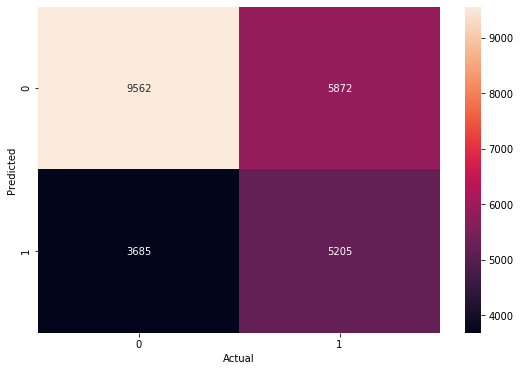

[[9562 5872]
 [3685 5205]]
------------------------*-------------------------
Classification par Regression logistique
              precision    recall  f1-score   support

           0       0.62      0.72      0.67     13247
           1       0.59      0.47      0.52     11077

    accuracy                           0.61     24324
   macro avg       0.60      0.60      0.59     24324
weighted avg       0.60      0.61      0.60     24324

---------Regréssion logistique - balanced---------
              precision    recall  f1-score   support

           0       0.63      0.60      0.61     13247
           1       0.55      0.58      0.56     11077

    accuracy                           0.59     24324
   macro avg       0.59      0.59      0.59     24324
weighted avg       0.59      0.59      0.59     24324



In [60]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix
y_pred_log = classifier.predict(X_test_log)

f, ax = plt.subplots(figsize=(9, 6))
cm = confusion_matrix(y_pred_log, y_test_log)

sns.heatmap(cm, annot=True, fmt = 'd', ax = ax)
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
plt.show()
print(cm)
print('*'.center(50,'-'))
print("Classification par Regression logistique")
print(classification_report(y_true = y_test_log, y_pred  = classifier.predict(X_test_log)))
print("Regréssion logistique - balanced".center(50,'-'))
print(classification_report(y_true = y_test_log, y_pred  = classifier_blcd.predict(X_test_log)))


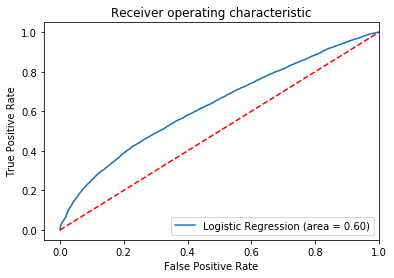

In [61]:
logit_roc_auc = roc_auc_score(y_test_log, classifier.predict(X_test_log))
fpr, tpr, thresholds = roc_curve(y_test_log, classifier.predict_proba(X_test_log)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [0]:
y=df['FGM']
X = df[[ 'place', 'game_result', 'shot_nb', 'game_clock','clock_remain',
        'dribbles', 'touch_time', 'shot_distance', 'defender_dist', 
        'shot_comment', 'stress' ]]

In [63]:
reg_log2 = smf.glm('FGM~clock_remain+touch_time+defender_dist+place+game_result+dribbles+stress+shot_comment',
                   data=df, family=sm.families.Binomial()).fit()
print(reg_log2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    FGM   No. Observations:               121620
Model:                            GLM   Df Residuals:                   121611
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -82859.
Date:                Tue, 18 Feb 2020   Deviance:                   1.6572e+05
Time:                        20:00:14   Pearson chi2:                 1.22e+05
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [0]:
y=df['FGM']
X = df[[ 'place', 'game_result', 'shot_nb', 'game_clock','clock_remain',
        'dribbles', 'touch_time', 'shot_distance', 'defender_dist', 
        'shot_comment', 'stress' ]]
X = pd.get_dummies(X)
X_columns = X.columns

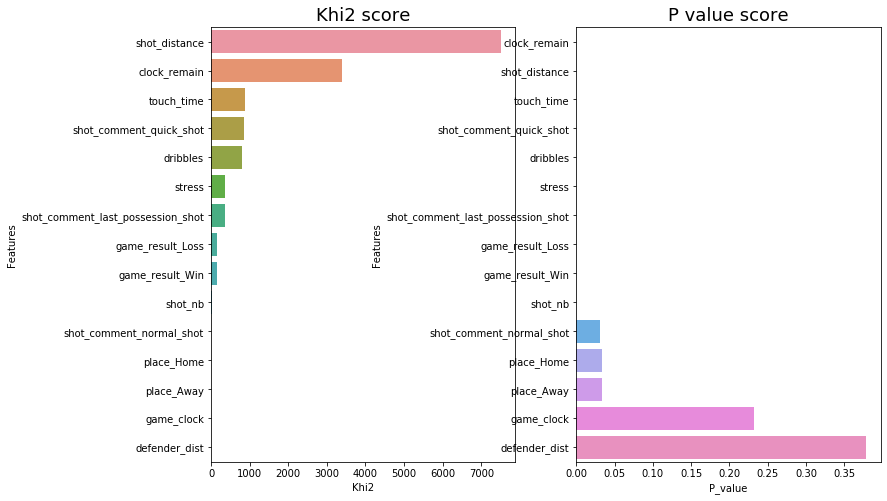

In [65]:
from sklearn.feature_selection import chi2
khi2 = chi2(X,y)
# Feature importance 
feature_ranking = pd.DataFrame({"Features": X_columns,
                                   "Khi2": khi2[0],
                                  "P_value" : khi2[1]})

feature_ranking.sort_values(by = "Khi2", ascending=False)


fig, axarr = plt.subplots(1,2, figsize=(12, 8))
sns.barplot(x="Khi2",y="Features", 
            data = feature_ranking.sort_values("Khi2", ascending=False),
            ax=axarr[0] )
sns.barplot(x="P_value",y="Features", 
            data = feature_ranking.sort_values("P_value", ascending=True),
            ax=axarr[1])
axarr[0].set_title("Khi2 score", fontsize=18)
axarr[1].set_title("P value score", fontsize=18)
plt.show()


## Decision Tree

In [0]:
y=df['FGM']
X = df[[ 'place', 'game_result', 'shot_nb', 'game_clock','clock_remain',
        'dribbles', 'touch_time', 'shot_distance', 'defender_dist', 
        'shot_comment', 'stress' ]]
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state = 42)
X_columns=X_train.columns

In [0]:
## recherche des meilleurs paramètres##
# {'criterion': 'gini',
#  'max_depth': 5,
#  'min_samples_leaf': 1002,
#  'splitter': 'best'}
# rl = DecisionTreeClassifier()
# params = {'max_depth' : np.arange(1,10),
#          'min_samples_leaf' : [1, 5, 10, 20],
#          'criterion': ['gini', 'entropy'],
#          'splitter': ['best', 'random'],
#          'min_samples_leaf' : [1,1002,200]}

# grid_log =  GridSearchCV(estimator=rl, param_grid= params, cv = 10)
# grid_log.fit(X_train, y_train)

In [68]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 5)
tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [69]:
print("Tree classifier".center(50, "-"))
print("Tree score on train :",tree.score(X_train, y_train))  ### donne l'accuracy
print("Tree score on test", tree.score(X_test, y_test))
#print("Tree score crossval =10", grid_log.best_score_)


-----------------Tree classifier------------------
Tree score on train : 0.6179699062654169
Tree score on test 0.6134270679164611


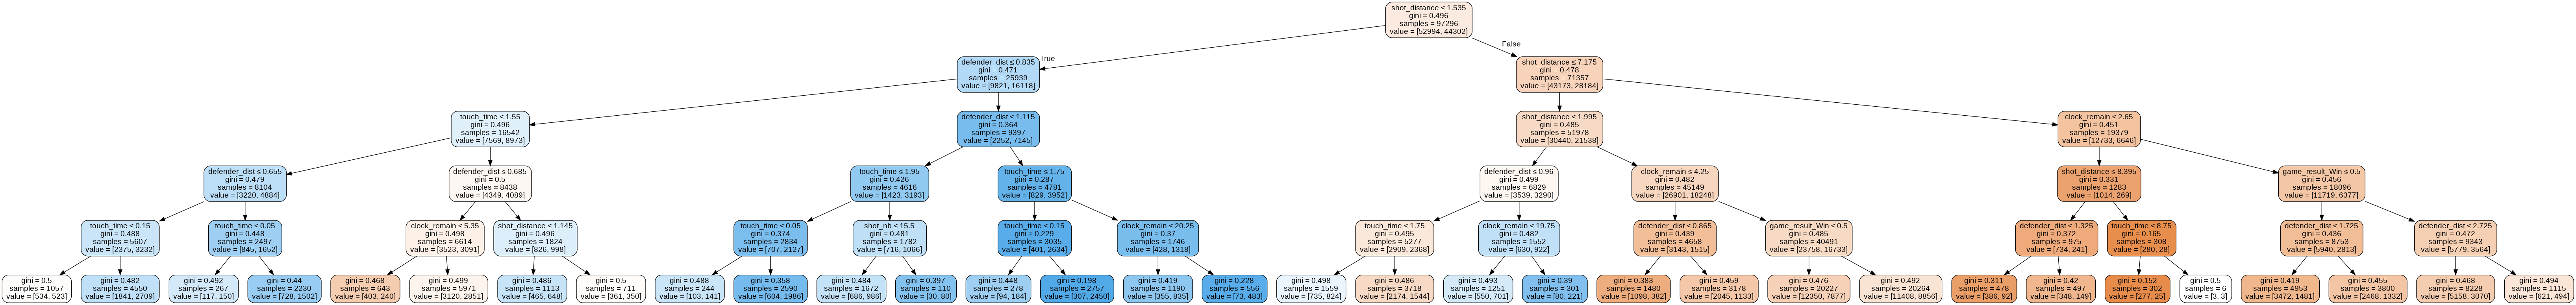

In [70]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

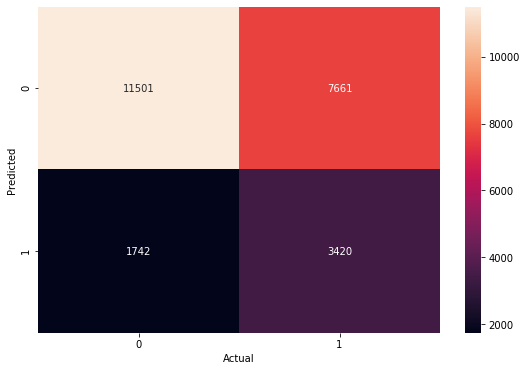

[[11501  7661]
 [ 1742  3420]]
--*--
Classification par Decision Tree
              precision    recall  f1-score   support

           0       0.60      0.87      0.71     13243
           1       0.66      0.31      0.42     11081

    accuracy                           0.61     24324
   macro avg       0.63      0.59      0.57     24324
weighted avg       0.63      0.61      0.58     24324



In [71]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix
y_pred_tree = tree.predict(X_test)

f, ax = plt.subplots(figsize=(9, 6))
cm = confusion_matrix(y_pred_tree, y_test)
sns.heatmap(cm, annot=True, fmt = 'd', ax = ax)
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
plt.show()
print(cm)
print('*'.center(5,'-'))
print("Classification par Decision Tree")
print(classification_report(y_true = y_test, y_pred  = tree.predict(X_test)))

Decision tree is poorer to predict field goald made

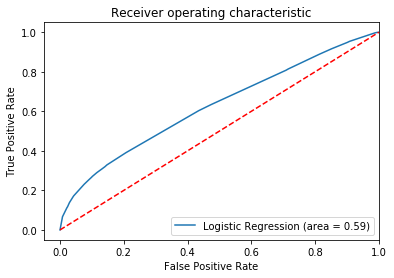

In [72]:
logit_roc_auc = roc_auc_score(y_test, tree.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

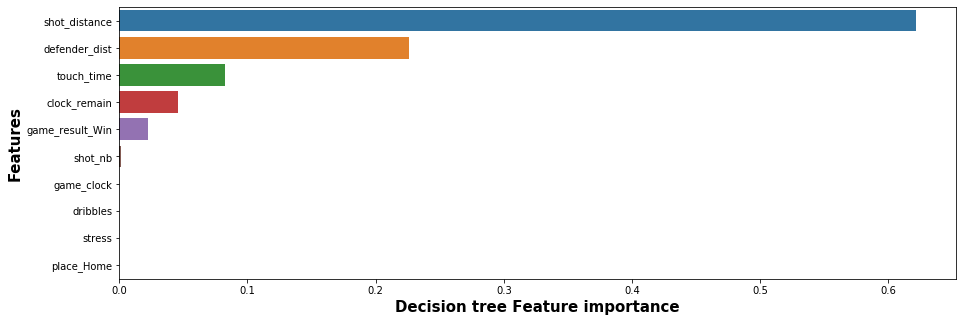

In [73]:
features_ranking_tree= pd.DataFrame(
    {'features' : X.columns,
    'importance' :tree.feature_importances_ }
).sort_values(by = 'importance', ascending = False)
sns.barplot(x="importance",y="features", 
            data = features_ranking_tree.sort_values("importance", ascending=False)[:10])
plt.gcf().set_size_inches(15, 5)
plt.yticks( size = 10)
plt.xlabel('Decision tree Feature importance', weight = 'bold', size = 15)
plt.ylabel('Features', weight = 'bold', size = 15)
plt.show()

## Random Forest

In [0]:
# ## recherche des meilleurs paramètres##
# rfc_cv = RandomForestClassifier()
# params = {'max_depth' : np.arange(1,9),
#          'n_estimators' : [50,100,150,200]}

# grid_rfc =  GridSearchCV(estimator=rfc_cv, param_grid= params, cv = 10)
# grid_rfc.fit(X_train, y_train)

In [75]:
from sklearn.ensemble import RandomForestClassifier
rfc= RandomForestClassifier( n_estimators = 100, 
                             max_depth = 5, 
                             min_samples_leaf = 300)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=300, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [76]:
print("Random Forest classifier".center(50, "-"))
print("Random Forest score on train :",rfc.score(X_train, y_train))  ### donne l'accuracy
print("Random Forest score on test", rfc.score(X_test, y_test))
#print("Random Forest score crossval =10", grid_rfc.best_score_)

# checking accuracy
dummy_tree = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_tree_pred = dummy_tree.predict(X_test)
print("Dummy tree ".center(50, "-"))
print('Unique predicted labels: ', (np.unique(dummy_pred)))
print('Dummy predictor Test score: ', accuracy_score(y_test, dummy_tree_pred))


-------------Random Forest classifier-------------
Random Forest score on train : 0.6169112810393027
Random Forest score on test 0.6136326262127939
-------------------Dummy tree --------------------
Unique predicted labels:  [0]
Dummy predictor Test score:  0.54444170366716


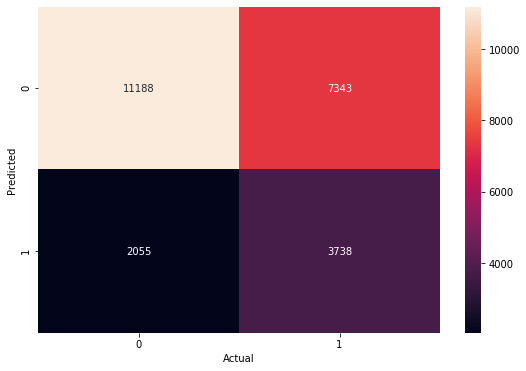

[[11188  7343]
 [ 2055  3738]]
------------------------*-------------------------
Classification par Random forest
              precision    recall  f1-score   support

           0       0.60      0.84      0.70     13243
           1       0.65      0.34      0.44     11081

    accuracy                           0.61     24324
   macro avg       0.62      0.59      0.57     24324
weighted avg       0.62      0.61      0.59     24324



In [77]:
# Confusion matrix 
y_pred_rfc = rfc.predict(X_test)

f, ax = plt.subplots(figsize=(9, 6))
cm = confusion_matrix(y_pred_rfc, y_test)
sns.heatmap(cm, annot=True, fmt = 'd', ax = ax)
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
plt.show()
print(cm)
print('*'.center(50,'-'))
print("Classification par Random forest")
print(classification_report(y_true = y_test, y_pred  = rfc.predict(X_test)))

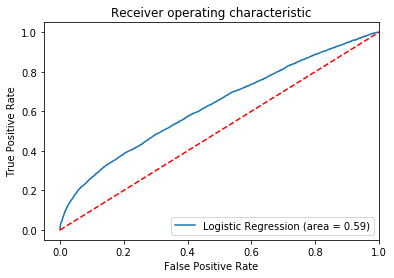

In [78]:
logit_roc_auc = roc_auc_score(y_test, rfc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

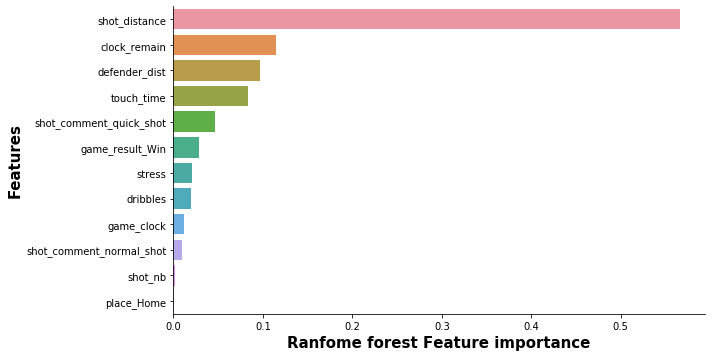

In [79]:
features_ranking_rfc= pd.DataFrame(
    {'features' : X.columns,
    'importance' :rfc.feature_importances_ }
).sort_values(by = 'importance', ascending = False)
sns.catplot(x="importance",y="features", 
            data = features_ranking_rfc.sort_values("importance", ascending=False)[:15],
            kind="bar")
plt.gcf().set_size_inches(15, 5)
plt.yticks( size = 10)
plt.xlabel('Ranfome forest Feature importance', weight = 'bold', size = 15)
plt.ylabel('Features', weight = 'bold', size = 15)
plt.show()

# ANALYSE DE l'ERREUR

### Modèle random Forest

In [0]:
y_train_rfc = y_train.reset_index()
y_train_tree= y_train_rfc.drop(['index'], axis = 1)
df_tree =pd.DataFrame(X_train, columns = X_columns)
df_tree['pred'] = rfc.predict(X_train)
df_tree['cible'] = y_train_tree
df_tree['gap'] = df_tree.pred - df_tree.cible

In [81]:
df_tree[(df_tree['gap'] == 0) &(df_tree['pred'] == 1) ].describe()  ## True Positive

,shot_nb,game_clock,clock_remain,dribbles,touch_time,shot_distance,defender_dist,stress,place_Home,game_result_Win,shot_comment_normal_shot,shot_comment_quick_shot,pred,cible,gap
count,8233.000000,8233.000000,8233.000000,8233.000000,8233.000000,8233.000000,8233.000000,8233.000000,8233.000000,8233.000000,8233.000000,8233.000000,8233.0,8233.0,8233.0
mean,6.113567,5.739855,15.748986,1.366938,2.047698,0.892501,0.879016,0.082352,0.507956,0.555205,0.600875,0.316774,1.0,1.0,0.0
std,4.272099,3.256391,6.069610,2.621083,2.323055,0.426011,0.715845,0.274916,0.499967,0.496973,0.489748,0.465247,0.0,0.0,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.0
25%,3.000000,3.110000,11.000000,0.000000,0.700000,0.580000,0.520000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.0
50%,5.000000,5.560000,16.200000,0.000000,1.200000,0.880000,0.760000,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0,0.0
75%,8.000000,8.400000,20.900000,2.000000,2.700000,1.190000,1.070000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.0
max,32.000000,11.570000,24.000000,26.000000,21.700000,5.030000,11.980000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.0


In [82]:
df_tree[df_tree['gap'] == -1].describe()## Faux négatifs

,shot_nb,game_clock,clock_remain,dribbles,touch_time,shot_distance,defender_dist,stress,place_Home,game_result_Win,shot_comment_normal_shot,shot_comment_quick_shot,pred,cible,gap
count,25273.000000,25273.000000,25273.000000,25273.000000,25273.000000,25273.000000,25273.000000,25273.000000,25273.000000,25273.000000,25273.000000,25273.000000,25273.0,25273.0,25273.0
mean,6.461322,5.816509,11.282115,2.101531,2.916433,5.162075,1.392401,0.191707,0.496023,0.496894,0.770664,0.037629,0.0,1.0,-1.0
std,4.643838,3.394928,5.241487,3.473783,2.988992,2.254975,0.819154,0.393651,0.499994,0.500000,0.420414,0.190301,0.0,0.0,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,-1.0
25%,3.000000,3.060000,7.400000,0.000000,0.900000,2.930000,0.820000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.0,-1.0
50%,5.000000,6.030000,11.400000,1.000000,1.800000,5.700000,1.280000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.0,-1.0
75%,9.000000,8.580000,15.100000,3.000000,3.900000,7.250000,1.740000,0.000000,1.000000,1.000000,1.000000,0.000000,0.0,1.0,-1.0
max,36.000000,11.570000,24.000000,27.000000,23.900000,12.740000,7.620000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.0,-1.0


### modèles regression


In [0]:
y_train_log = pd.DataFrame(y_train_log)
y_train_log.reset_index(drop=True, inplace = True)

#X_train_log_error.reset_index(drop=True, inplace = True)

df_log =pd.DataFrame(sc_x.inverse_transform(X_train_num_norm), columns = X_train_num_norm.columns, index =X_train_num.index)

df_log_error = pd.merge(df_log, X_train_cat, left_index=True, right_index=True  )
df_log_error['pred'] = classifier.predict(X_train_log)
df_log_error['cible'] = y_train_log
df_log_error['gap'] = df_log_error.pred - df_log_error.cible

In [84]:
df_log_error[(df_log_error['gap'] == 0) &(df_log_error['pred'] == 1) ].describe()  ## True Positive

,shot_nb,game_clock,clock_remain,dribbles,touch_time,shot_distance,defender_dist,stress,place_Home,game_result_Win,shot_comment_normal_shot,shot_comment_quick_shot,pred,cible,gap
count,12372.000000,12372.000000,1.237200e+04,1.237200e+04,12372.000000,12372.000000,12372.000000,12372.000000,12372.000000,12372.000000,12372.000000,12372.000000,12372.0,12372.0,12372.0
mean,6.199644,5.816578,1.511860e+01,1.477530e+00,2.089476,1.700613,1.142589,0.074846,0.514226,0.602894,0.689298,0.235855,1.0,1.0,0.0
std,4.335748,3.291589,5.723989e+00,2.510905e+00,2.081373,1.640842,1.023859,0.263154,0.499818,0.489318,0.462800,0.424549,0.0,0.0,0.0
min,1.000000,0.000000,-1.776357e-15,2.220446e-16,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.0
25%,3.000000,3.130000,1.090000e+01,2.220446e-16,0.800000,0.730000,0.580000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.0
50%,5.000000,6.020000,1.520000e+01,2.220446e-16,1.300000,1.190000,0.850000,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0,0.0
75%,9.000000,8.480000,1.990000e+01,2.000000e+00,2.800000,1.920000,1.250000,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0,0.0
max,33.000000,12.000000,2.400000e+01,2.300000e+01,16.800000,10.580000,11.980000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.0


In [85]:
df_log_error[df_log_error['gap'] == -1].describe()## Faux négatifs

,shot_nb,game_clock,clock_remain,dribbles,touch_time,shot_distance,defender_dist,stress,place_Home,game_result_Win,shot_comment_normal_shot,shot_comment_quick_shot,pred,cible,gap
count,21131.000000,21131.000000,2.113100e+04,2.113100e+04,21131.00000,21131.000000,21131.000000,21131.000000,21131.000000,21131.000000,21131.000000,21131.000000,21131.0,21131.0,21131.0
mean,6.427807,5.822182,1.081362e+01,2.232881e+00,3.09496,5.544337,1.335627,0.215371,0.483460,0.450286,0.752828,0.031802,0.0,1.0,-1.0
std,4.662528,3.416890,5.207601e+00,3.781872e+00,3.25065,2.105429,0.650216,0.411089,0.499738,0.497534,0.431378,0.175476,0.0,0.0,0.0
min,1.000000,0.000000,-1.776357e-15,2.220446e-16,0.00000,0.030000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,-1.0
25%,3.000000,3.050000,6.850000e+00,2.220446e-16,0.90000,4.020000,0.850000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.0,-1.0
50%,5.000000,6.020000,1.090000e+01,1.000000e+00,1.80000,6.100000,1.310000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.0,-1.0
75%,9.000000,9.000000,1.470000e+01,3.000000e+00,4.20000,7.380000,1.710000,0.000000,1.000000,1.000000,1.000000,0.000000,0.0,1.0,-1.0
max,35.000000,12.000000,2.400000e+01,2.700000e+01,23.50000,12.740000,6.740000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.0,-1.0


In [0]:
# for i in df_log_error.columns[:-3]:
#     sns.catplot(x="pred", y=i, hue="pred", kind="box", data=df_log_error);
#     plt.show()

In [0]:
# for i in df_log_error.columns[:-3]:
#     sns.pointplot(x = i, y = 'cible', hue='pred', data = df_log_error, join = False, ci = None)
#     plt.show()

## Deep learning

In [0]:
# try to see if a fastai ai tabular learner can perform better
from fastai.tabular import *

In [0]:
dataset = df.loc[:,['shot_nb', 'game_clock','clock_remain',
        'dribbles', 'touch_time', 'shot_distance', 'defender_dist', 
        'shot_comment', 'stress', 'FGM']]

In [177]:
# identify continue and categorical features
conts, cats = cont_cat_split(dataset, dep_var="FGM")
for cont in conts:
  print("variables continues : {}".format(cont))
for cat in cats:
  print("variables catégoriques : {}".format(cat))

variables continues : shot_nb
variables continues : game_clock
variables continues : clock_remain
variables continues : dribbles
variables continues : touch_time
variables continues : shot_distance
variables continues : defender_dist
variables catégoriques : shot_comment
variables catégoriques : stress


In [178]:
# These three methods will be used in the creation of the dataset
preprocessing = [FillMissing, Categorify, Normalize]
print(preprocessing)

[<class 'fastai.tabular.transform.FillMissing'>, <class 'fastai.tabular.transform.Categorify'>, <class 'fastai.tabular.transform.Normalize'>]


In [0]:
# train_validation split
mask = np.random.randn(len(dataset)) <0.8
dataset_train = dataset[mask]
dataset_test = dataset[~mask]

In [0]:
#Tabular databunch for fast ai 
data = TabularDataBunch.from_df(Path(),
                                dataset,
                                dep_var="FGM",
                                valid_idx=dataset_test.index,
                                procs=preprocessing,
                                cat_names = cats
                                )

In [181]:
data

TabularDataBunch;

Train: LabelList (100887 items)
x: TabularList
shot_comment normal_shot; stress 0; clock_remain_na False; game_clock -1.3226; dribbles -0.0067; shot_nb -1.1685; clock_remain -0.2772; shot_distance -0.6607; defender_dist -1.0218; touch_time -0.2900; ,shot_comment last_possession_shot; stress 1; clock_remain_na False; game_clock -1.6384; dribbles 0.2802; shot_nb -0.7447; clock_remain -2.1753; shot_distance -0.3913; defender_dist -1.1769; touch_time -0.0235; ,shot_comment normal_shot; stress 0; clock_remain_na False; game_clock 1.6850; dribbles -0.0067; shot_nb -0.5328; clock_remain -0.3651; shot_distance 0.4059; defender_dist -0.2582; touch_time -0.2900; ,shot_comment normal_shot; stress 0; clock_remain_na False; game_clock 1.3576; dribbles -0.0067; shot_nb -0.3209; clock_remain -0.2596; shot_distance -1.1109; defender_dist -1.0934; touch_time -0.0235; ,shot_comment normal_shot; stress 0; clock_remain_na False; game_clock 0.7230; dribbles -0.0067; shot_nb -0.1090; cloc

In [0]:
# dictionaries of the different values that our categorical variables can have
dico = {key: dataset[key].nunique() for key in dataset.loc[:, cats]}

In [0]:
learn = tabular_learner(data,layers=[400] ,metrics=[accuracy, Recall(pos_label=1)], emb_szs=dico)

In [0]:
learner_made = tabular_learner(data,layers=[600] ,metrics=Recall(pos_label= 1), emb_szs=dico)

In [185]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(3, 2)
    (2): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=400, out_features=2, bias=True)
  )
)

In [186]:
learner_made.fit_one_cycle(5)

epoch,train_loss,valid_loss,recall,time
0,0.692162,0.704791,0.518714,00:14
1,0.666453,0.660487,0.394874,00:14
2,0.658153,0.651918,0.396827,00:14
3,0.651523,0.650368,0.375834,00:15
4,0.646769,0.649882,0.346216,00:14


In [187]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,recall,time
0,0.662527,0.656428,0.618093,0.364849,00:15
1,0.660356,0.650204,0.619528,0.360618,00:15


In [188]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


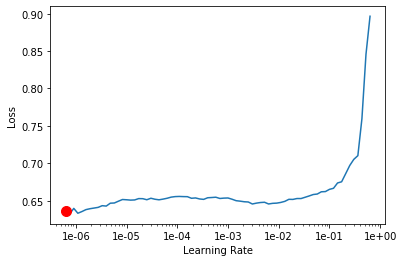

In [189]:
learn.recorder.plot(suggestion=True)

In [0]:
learn.unfreeze()

In [191]:
learn.fit_one_cycle(5, 5.75E-06)

epoch,train_loss,valid_loss,accuracy,recall,time
0,0.655842,0.650550,0.621183,0.383889,00:14
1,0.643763,0.650297,0.620926,0.353377,00:15
2,0.657590,0.650210,0.620006,0.365663,00:14
3,0.649269,0.650099,0.620300,0.359154,00:15
4,0.646907,0.650025,0.620742,0.368023,00:15


In [0]:
learner_made.unfreeze()

In [193]:
learner_made.lr_find()

epoch,train_loss,valid_loss,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-05
Min loss divided by 10: 2.51E-04


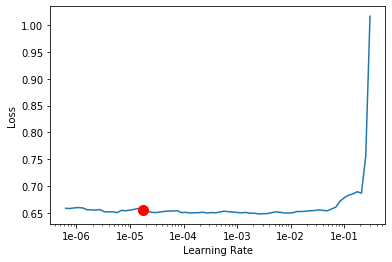

In [194]:
learner_made.recorder.plot(suggestion = True)

In [195]:
learner_made.fit_one_cycle(10, 9.12E-07)

epoch,train_loss,valid_loss,recall,time
0,0.648668,0.650136,0.377136,00:15
1,0.652499,0.649557,0.349390,00:14
2,0.655635,0.649937,0.382018,00:14
3,0.653100,0.649998,0.344833,00:15
4,0.653081,0.650623,0.356143,00:14
5,0.648689,0.649946,0.355736,00:14
6,0.648678,0.649854,0.366721,00:14
7,0.654163,0.650266,0.372417,00:14
8,0.642920,0.649851,0.356713,00:15
9,0.648432,0.650803,0.378763,00:15


In [196]:
interp = ClassificationInterpretation.from_learner(learn)

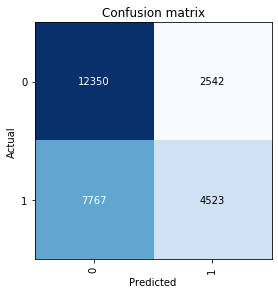

In [197]:
interp.plot_confusion_matrix()

In [198]:
interp = ClassificationInterpretation.from_learner(learner_made)

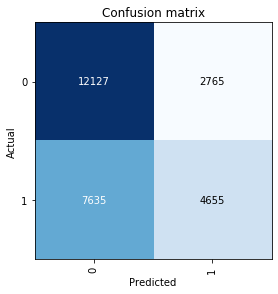

In [199]:
interp.plot_confusion_matrix()